# Inspecting jars from Maven

With the cpggen server, joern-lib enables inspecting jar files from maven directly. This notebook captures the steps involved, along with showcasing some sample queries.

In [1]:
import asyncio
from graphviz import Source

from joern_lib import client, workspace, graph
from joern_lib.detectors import common as cpg, java
from joern_lib.utils import print_table, print_tree, print_flows, read_image

joern_host = "http://joern:9000"
cpggen_host = "http://cpggen:7072"
joern_username = "admin"
joern_password  = "admin"

## Generate CPG using cpggen


CPG for the `commons-io` maven jar is generated using the atomgen server and then imported onto the joern server.
The default docker-compose starts a cpggen server with the hostname cpggen and port `7072`.


We use the `create_cpg` api from the workspace to create a CPG from the package URL directly. This single call would handle both generations of the cpg and import onto joern.


In [3]:
async def generate_cpg():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    await workspace.create_cpg(connection, "pkg:maven/org.apache.commons/commons-io@1.3.2")
asyncio.run(generate_cpg())

╭────────────────────────────────── CPGQL Query ──────────────────────────────────╮
│ os.exists(os.Path("/tmp/cpggen_cpg_out4wbx6hqi/cpggenkm3xwj07-jimple.cpg.bin")) │
╰─────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────────────────────── CPGQL Query ────────────────────────────────────────╮
│ importCpg("/tmp/cpggen_cpg_out4wbx6hqi/cpggenkm3xwj07-jimple.cpg.bin", "commons-io-1.3.2") │
╰────────────────────────────────────────────────────────────────────────────────────────────╯
╭─ CPGQL Query ─╮
│ save          │
╰───────────────╯


## Inspect methods

joern-lib offers a convenient api called `list_methods` to simplify the inspection. You can invoke this method without arguments to receive a full list of methods or provide a regex such as `.*org.apache.commons.io.CopyUtils.*` to narrow the results.

In [5]:
async def inspect_methods():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    res = await cpg.list_methods(connection, ".*org.apache.commons.io.CopyUtils.*")
    print_table(res, title="CopyUtils methods")
asyncio.run(inspect_methods())

╭─────────────────────────────────────────────────── CPGQL Query ───────────────────────────────────────────────────╮
│ cpg.method.fullName(".*org.apache.commons.io.CopyUtils.*").whereNot(_.name(".*<(operator|init)>.*")).toJsonPretty │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                 CopyUtils methods                                                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ name ┃ fullName                 ┃ signature                ┃ lineNumberEnd ┃ _label ┃ code                    ┃ isExternal ┃ lineNumber ┃  id ┃ order ┃ filename                 ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━

## Research CVE-2021-29425

> In Apache Commons IO before 2.7, When invoking the method FileNameUtils.normalize with an improper input string, like "//../foo", or "\\..\foo", the result would be the same value, thus possibly providing access to files in the parent directory

In [7]:
async def inspect_normalize():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    res = await cpg.list_methods(connection, ".*FilenameUtils.normalize:.*")
    print_table(res, title="FileNameUtils normalize method")
asyncio.run(inspect_normalize())

╭─────────────────────────────────────────────── CPGQL Query ────────────────────────────────────────────────╮
│ cpg.method.fullName(".*FilenameUtils.normalize:.*").whereNot(_.name(".*<(operator|init)>.*")).toJsonPretty │
╰────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                           FileNameUtils normalize method                                                                           
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ name      ┃ fullName               ┃ signature              ┃ lineNumberEnd ┃ _label ┃ code                   ┃ isExternal ┃ lineNumber ┃   id ┃ order ┃ filename                ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━

In [8]:
async def get_call_tree():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    res = await cpg.get_call_tree(connection, "org.apache.commons.io.FilenameUtils.normalize:java.lang.String(java.lang.String)")
    print_tree(res)
asyncio.run(get_call_tree())

org.apache.commons.io.FilenameUtils.normalize:java.lang.String(java.lang.String)
┣━━ |    org.apache.commons.io.FilenameUtils.doNormalize:java.lang.String(java.lang.String,boolean)
┣━━ java.lang.String.getChars:void(int,int,char[],int)
┣━━ |    java.lang.System.arraycopy:void(java.lang.Object,int,java.lang.Object,int,int)
┣━━ |    |    java.lang.System.arraycopy:void(java.lang.Object,int,java.lang.Object,int,int)
┣━━ |    |    |    java.lang.System.arraycopy:void(java.lang.Object,int,java.lang.Object,int,int)
┣━━ |    |    |    |    java.lang.System.arraycopy:void(java.lang.Object,int,java.lang.Object,int,int)
┣━━ |    |    |    |    |    java.lang.String.<init>:void(char[],int,int)
┣━━ |    |    |    |    |    |    java.lang.String.<init>:void(char[],int,int)
┣━━ |    |    |    |    |    |    |    java.lang.String.<init>:void(char[],int,int)
┣━━ |    |    |    |    |    |    |    |    java.lang.String.length:int()
┣━━ |    |    |    |    |    |    |    |    |    org.apache.commons.io.

We can see the method is invoking another method called `doNormalize`

In [10]:
async def inspect_do_normalize():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    res = await cpg.list_methods(connection, ".*FilenameUtils.doNormalize:.*")
    print_table(res, title="FileNameUtils doNormalize method")
    print("\n")
    res = await cpg.get_call_tree(connection, "org.apache.commons.io.FilenameUtils.doNormalize:java.lang.String(java.lang.String,boolean)")
    print_tree(res)
asyncio.run(inspect_do_normalize())

╭──────────────────────────────────────────────── CPGQL Query ─────────────────────────────────────────────────╮
│ cpg.method.fullName(".*FilenameUtils.doNormalize:.*").whereNot(_.name(".*<(operator|init)>.*")).toJsonPretty │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                          FileNameUtils doNormalize method                                                                          
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ name        ┃ fullName               ┃ signature             ┃ lineNumberEnd ┃ _label ┃ code                   ┃ isExternal ┃ lineNumber ┃    id ┃ order ┃ filename              ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━

A method called getPrefixLength is found in the call trees for both normalize and doNormalize. The final step is to visualize the call tree for getPrefixLength

In [12]:
async def get_call_tree():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    res = await cpg.get_call_tree(connection, "org.apache.commons.io.FilenameUtils.getPrefixLength:int(java.lang.String)")
    print_tree(res)
asyncio.run(get_call_tree())

org.apache.commons.io.FilenameUtils.getPrefixLength:int(java.lang.String)
┣━━ |    java.lang.String.length:int()
┣━━ java.lang.String.charAt:char(int)
┣━━ org.apache.commons.io.FilenameUtils.isSeparator:boolean(char)
┣━━ java.lang.String.indexOf:int(int,int)
┣━━ java.lang.Math.min:int(int,int)
┗━━ java.lang.Character.toUpperCase:char(char)


From the call tree for `getPrefixLength`, we can observe that apart from some `isSeparator` checks, there isn't much validation in the method. Therefore, this method could become a target for detailed testing, including fuzzing.

# Hunting RCE in commons-text

## Generate CPG

In [16]:
async def generate_cpg():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    await workspace.create_cpg(connection, "pkg:maven/org.apache.commons/commons-text@1.10.0")
asyncio.run(generate_cpg())

╭────────────────────────────────── CPGQL Query ──────────────────────────────────╮
│ os.exists(os.Path("/tmp/cpggen_cpg_outcq8213iy/cpggenkvbwnt5m-jimple.cpg.bin")) │
╰─────────────────────────────────────────────────────────────────────────────────╯
╭───────────────────────────────────────── CPGQL Query ─────────────────────────────────────────╮
│ importCpg("/tmp/cpggen_cpg_outcq8213iy/cpggenkvbwnt5m-jimple.cpg.bin", "commons-text-1.10.0") │
╰───────────────────────────────────────────────────────────────────────────────────────────────╯
╭─ CPGQL Query ─╮
│ save          │
╰───────────────╯


## Research CVE-2022-42889

> The StringSubstitutor when used with the default interpolators (StringSubstitutor.createInterpolator()) will perform string lookups that may lead to arbitrary code execution.

In particular, if untrusted data flows into the StringSubstitutor.replace() or StringSubstitutor.replaceIn() methods, an attacker will be able to use the ScriptStringLookup to trigger arbitrary code execution.

In [18]:
async def get_call_tree():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    res = await cpg.get_call_tree(connection, "org.apache.commons.text.lookup.ScriptStringLookup.lookup:java.lang.String(java.lang.String)")
    print_tree(res)
asyncio.run(get_call_tree())

org.apache.commons.text.lookup.ScriptStringLookup.lookup:java.lang.String(java.lang.String)
┣━━ |    javax.script.ScriptEngineManager.<init>:void()
┣━━ java.lang.StringBuilder.<init>:void()
┣━━ java.lang.IllegalArgumentException.<init>:void(java.lang.String)
┣━━ java.lang.String.split:java.lang.String[](java.lang.String,int)
┣━━ org.apache.commons.text.lookup.IllegalArgumentExceptions.format:java.lang.IllegalArgumentException(java.lang.String,java.lang.Object[])
┣━━ java.lang.String.format:java.lang.String(java.lang.String,java.lang.Object[])
┣━━ |    javax.script.ScriptEngineManager.getEngineByName:javax.script.ScriptEngine(java.lang.String)
┣━━ |    |    java.lang.StringBuilder.append:java.lang.StringBuilder(java.lang.String)
┣━━ |    |    |    java.lang.StringBuilder.append:java.lang.StringBuilder(java.lang.String)
┣━━ |    |    |    |    java.lang.StringBuilder.toString:java.lang.String()
┣━━ |    |    |    |    |    javax.script.ScriptEngine.eval:java.lang.Object(java.lang.String)

The call tree shows that the lookup method invokes `javax.script.ScriptEngine.eval` without validation or sanitization. Let's prove that the flow exists from the input parameter to the eval method using joern.

In [20]:
async def detect_lookup_rce(connection=None):
    if not connection:
        connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    await client.df(connection, 'cpg.parameter', 'cpg.method.fullNameExact("javax.script.ScriptEngine.eval:java.lang.Object(java.lang.String)").parameter.order(1)')
asyncio.run(detect_lookup_rce())

╭─────── CPGQL Query ────────╮
│ def source = cpg.parameter │
╰────────────────────────────╯
╭──────────────────────────────────────────────────────── CPGQL Query ────────────────────────────────────────────────────────╮
│ def sink = cpg.method.fullNameExact("javax.script.ScriptEngine.eval:java.lang.Object(java.lang.String)").parameter.order(1) │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────────────────────────────────── CPGQL Query ───────────────────────────────────────────────────╮
│ sink.reachableByFlows(source).map(m => (m, m.elements.location.l)).toJson |> "/tmp/reachable_flows_2gtoyqve.json" │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─ Tainted Identifiers ─╮
│ key                   │
│ keys                  │
│ engineName            │
│ scriptEngine          │
│ script                │
╰────────────

## Variant analysis

We have proved with data flow that commons-text version 1.10.0 has the RCE vulnerability. What about other versions such as 1.9 or 1.8 etc? joern-lib makes variant analysis a breeze.

In [22]:
async def generate_versioned_cpg():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    for version in ("1.10.0", "1.9", "1.8", "1.7"):
        print (f"Checking commons-text {version}")
        await workspace.create_cpg(connection, f"pkg:maven/org.apache.commons/commons-text@{version}")
        await detect_lookup_rce(connection)        
asyncio.run(generate_versioned_cpg())

Checking commons-text 1.10.0
╭────────────────────────────────── CPGQL Query ──────────────────────────────────╮
│ os.exists(os.Path("/tmp/cpggen_cpg_out7l0meamw/cpggent85t6kzu-jimple.cpg.bin")) │
╰─────────────────────────────────────────────────────────────────────────────────╯
╭───────────────────────────────────────── CPGQL Query ─────────────────────────────────────────╮
│ importCpg("/tmp/cpggen_cpg_out7l0meamw/cpggent85t6kzu-jimple.cpg.bin", "commons-text-1.10.0") │
╰───────────────────────────────────────────────────────────────────────────────────────────────╯
╭─ CPGQL Query ─╮
│ save          │
╰───────────────╯
╭─────── CPGQL Query ────────╮
│ def source = cpg.parameter │
╰────────────────────────────╯
╭──────────────────────────────────────────────────────── CPGQL Query ────────────────────────────────────────────────────────╮
│ def sink = cpg.method.fullNameExact("javax.script.ScriptEngine.eval:java.lang.Object(java.lang.String)").parameter.order(1) │
╰─────────────────────

# Advanced graph users

joern-lib exposes methods to interact with the method pdg or cpg graphs directly.

In [24]:
async def generate_cpg():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    await workspace.create_cpg(connection, "pkg:maven/org.apache.commons/commons-io@1.3.2")
asyncio.run(generate_cpg())

╭────────────────────────────────── CPGQL Query ──────────────────────────────────╮
│ os.exists(os.Path("/tmp/cpggen_cpg_outu6ur4q7a/cpggenpve0wx1e-jimple.cpg.bin")) │
╰─────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────────────────────── CPGQL Query ────────────────────────────────────────╮
│ importCpg("/tmp/cpggen_cpg_outu6ur4q7a/cpggenpve0wx1e-jimple.cpg.bin", "commons-io-1.3.2") │
╰────────────────────────────────────────────────────────────────────────────────────────────╯
╭─ CPGQL Query ─╮
│ save          │
╰───────────────╯


╭─────────────────────────────────────────────────────── CPGQL Query ───────────────────────────────────────────────────────╮
│ cpg.method.fullNameExact("org.apache.commons.io.FilenameUtils.getPrefixLength:int(java.lang.String)").dotPdg.toJsonPretty │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


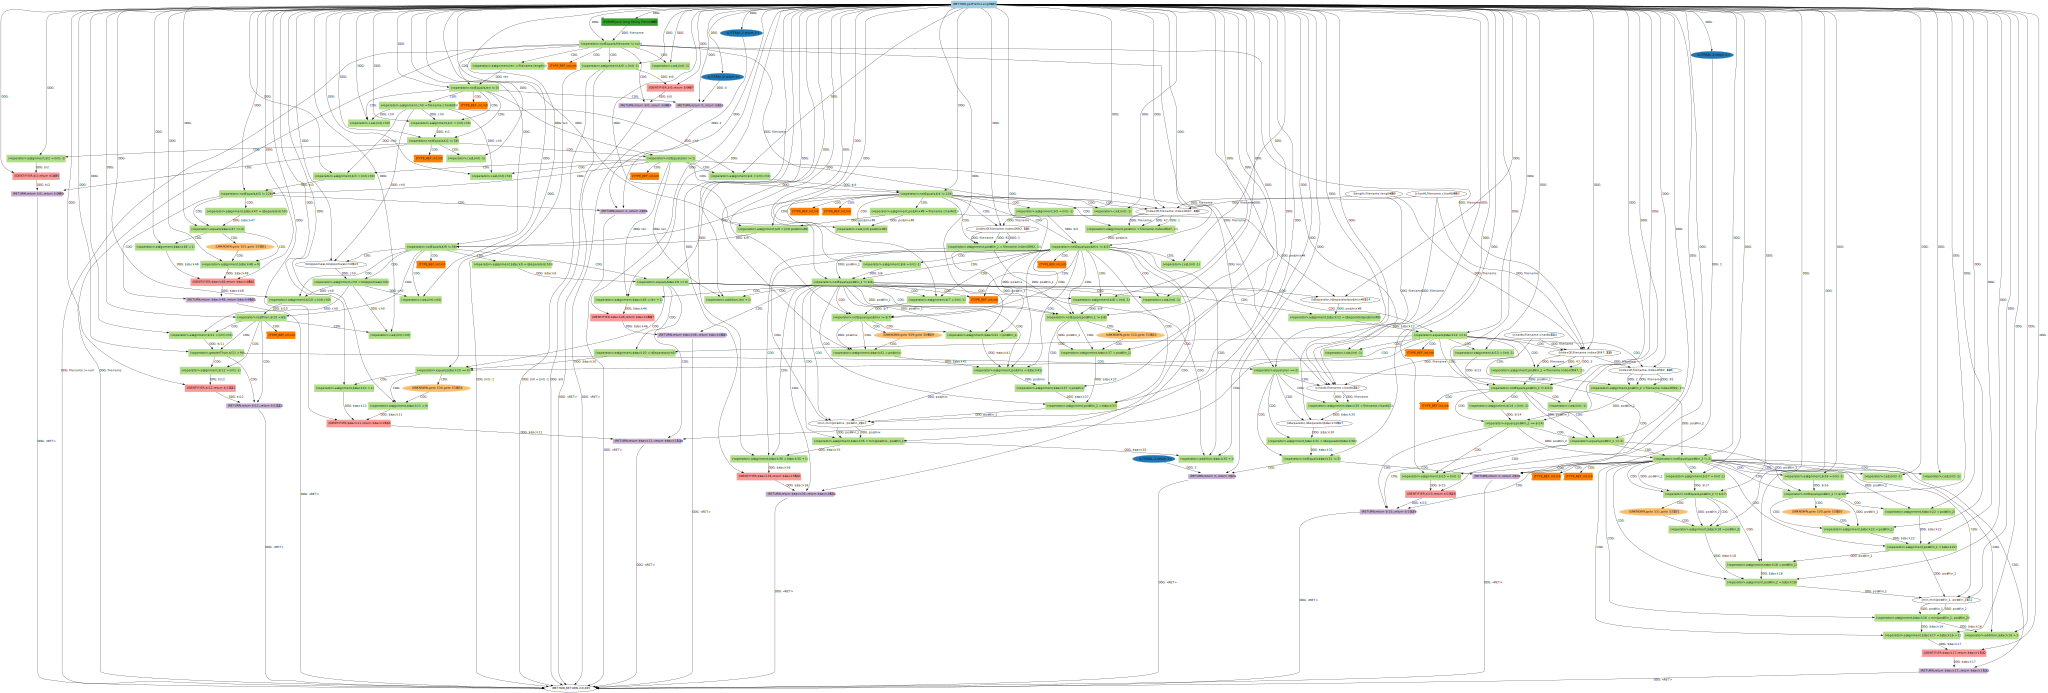

In [25]:
async def export_method_pdg():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    res = await cpg.export(connection, "org.apache.commons.io.FilenameUtils.getPrefixLength:int(java.lang.String)")
    Source(res).render(filename="/tmp/getPrefixLength", engine="dot", format="svg")
    kernel.display.content("image/svg+xml", read_image("/tmp/getPrefixLength.svg"))
asyncio.run(export_method_pdg())

In [26]:
async def diff_method_pdg():
    connection = await client.get(joern_host, cpggen_host, joern_username, joern_password)
    L = await cpg.get_method(connection, "org.apache.commons.io.FilenameUtils.normalize:java.lang.String(java.lang.String)", as_graph=True)
    R = await cpg.get_method(connection, "org.apache.commons.io.FilenameUtils.doNormalize:java.lang.String(java.lang.String,boolean)", as_graph=True)
    diff = graph.diff_graph(L, R)
    print (diff.nodes, diff.edges)    
asyncio.run(diff_method_pdg())

['-\n        public static java.lang.String normalize(java.lang.String)\n    {\n        java.lang.String filename, $stack1;\n\n        filename := @parameter0: java.lang.String;\n\n        $stack1 = staticinvoke <org.apache.commons.io.FilenameUtils: java.lang.String doNormalize(java.lang.String,boolean)>(filename, 1);\n\n        return $stack1;\n    }\n      ', '-doNormalize(filename, 1)', '-java.lang.String $stack1', '-$stack1', '-$stack1 = doNormalize(filename, 1)', '-public', '-return $stack1;', '+arraycopy(array, i_2, array, $stack90, $stack89)', '+i_2 - 4', '+(int) $stack62', '+$stack18', '+i_1#3 = 0', '+keepSeparator == 0', '+(int) $stack25', '+char $stack87', '+2', '+$stack51 = i_2 - 3', '+size + $i8', '+int $stack89', '+(int) $stack26', '+$i9', '+array[$stack91]', '+$stack10', '+(int) $stack30', '+(int) $stack15', '+array', '+$stack90', '+$i20', '+int $stack31', '+$i1', '+$i3 = (int) $stack15', '+$stack40', '+i_2 != $stack34', '+(int) $stack32', '+$stack26', '+private', '+$stac

Future exception was never retrieved
future: <Future finished exception=ConnectionClosedError(None, None, None)>
Traceback (most recent call last):
  File "/opt/polynote/tmp/joern-notes/maven.ipynb/venv/lib64/python3.9/site-packages/websockets/legacy/protocol.py", line 959, in transfer_data
    message = await self.read_message()
  File "/opt/polynote/tmp/joern-notes/maven.ipynb/venv/lib64/python3.9/site-packages/websockets/legacy/protocol.py", line 1029, in read_message
    frame = await self.read_data_frame(max_size=self.max_size)
  File "/opt/polynote/tmp/joern-notes/maven.ipynb/venv/lib64/python3.9/site-packages/websockets/legacy/protocol.py", line 1104, in read_data_frame
    frame = await self.read_frame(max_size)
  File "/opt/polynote/tmp/joern-notes/maven.ipynb/venv/lib64/python3.9/site-packages/websockets/legacy/protocol.py", line 1161, in read_frame
    frame = await Frame.read(
  File "/opt/polynote/tmp/joern-notes/maven.ipynb/venv/lib64/python3.9/site-packages/websockets/le